In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch, time, os, sys
import numpy as np
import scipy.integrate, scipy.ndimage
from nn_model import MLP
from hnn import hnn
from data import get_dataset, get_orbit, sjs, potential_energy, kinetic_energy, total_energy, get_nn_orbit


def get_args():
    return {
        'nonlinearity': 'tanh', 'hidden_dim': 300, 'input_dim': 18, 'learning_rate': 0.001, 'batch_size': 25000,
        'total_steps': 20000, 'print_every': 1000, 'name': 'sjs', 'verbose': True, 'field_type': 'solenoidal',
        'seed': 0, 'save_dir': '/home/kevin/code/project/planetary'}


class ObjectView(object):
    def __init__(self, d): self.__dict__ = d



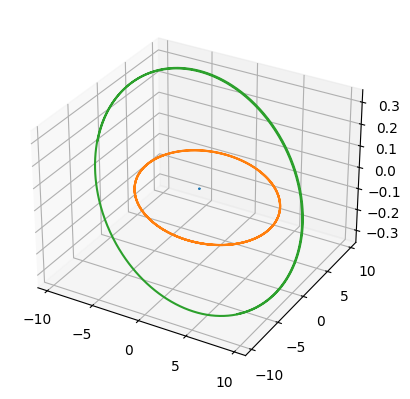

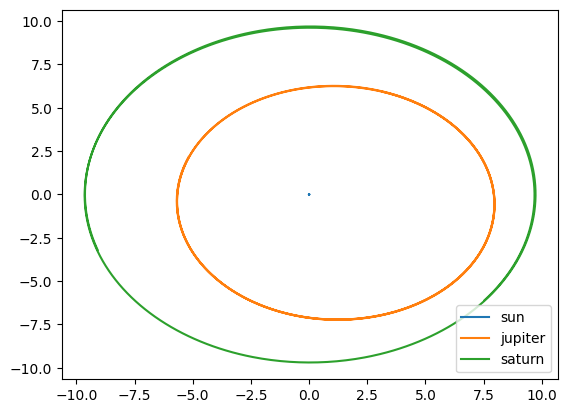

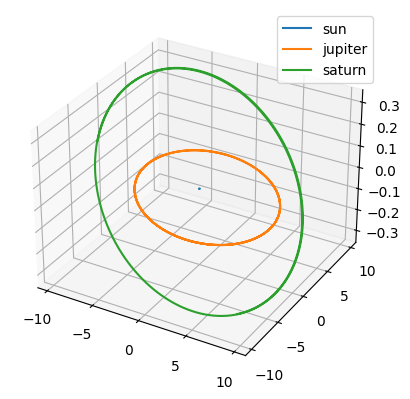

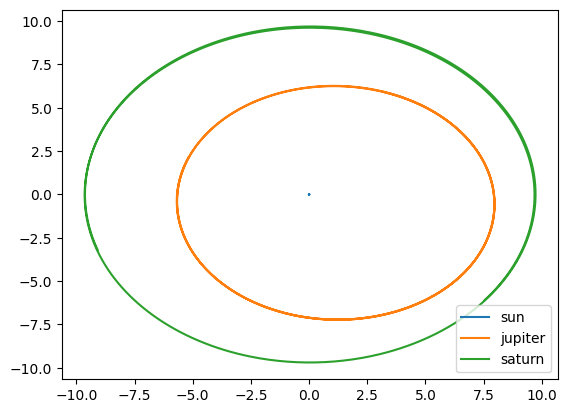

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.54300000e-04 -5.18368241e+00  2.14329706e+00  4.75515155e-02
  -1.10212705e+00 -2.66555518e+00  0.00000000e+00]
 [ 2.85700000e-04  7.54572992e+00 -6.09237820e+00 -3.43760374e-01
   1.26202644e+00  1.56308593e+00  0.00000000e+00]]


In [3]:
args = ObjectView(get_args())
np.random.seed(0)
state = sjs()
orbit, settings = get_orbit(state, t_points=1000, t_span=[0, 50], rtol=1e-9)

#3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(orbit[0][1], orbit[0][2], orbit[0][3], label='sun')
ax.plot(orbit[1][1], orbit[1][2], orbit[1][3], label='jupiter')
ax.plot(orbit[2][1], orbit[2][2], orbit[2][3], label='saturn')

#make a xy plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(orbit[0][1], orbit[0][2], label='sun')
ax.plot(orbit[1][1], orbit[1][2], label='jupiter')
ax.plot(orbit[2][1], orbit[2][2], label='saturn')

ax.legend()
plt.show()

import rebound

sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')
#add state to sim
sim.add(m=state[0][0], x=state[0][1], y=state[0][2], z=state[0][3], vx=state[0][4], vy=state[0][5], vz=state[0][6])
sim.add(m=state[1][0], x=state[1][1], y=state[1][2], z=state[1][3], vx=state[1][4], vy=state[1][5], vz=state[1][6])
sim.add(m=state[2][0], x=state[2][1], y=state[2][2], z=state[2][3], vx=state[2][4], vy=state[2][5], vz=state[2][6])
sim.move_to_com()
sim.integrator = "whfast"
sim.dt = 0.01

t = np.linspace(0, 50, 1000)
su = np.zeros((len(t), 3))
j = np.zeros((len(t), 3))
s = np.zeros((len(t), 3))
for i, time in enumerate(t):
    sim.integrate(time)
    su[i] = [sim.particles[0].x, sim.particles[0].y, sim.particles[0].z]
    j[i] = [sim.particles[1].x, sim.particles[1].y, sim.particles[1].z]
    s[i] = [sim.particles[2].x, sim.particles[2].y, sim.particles[2].z]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(su[:, 0], su[:, 1], su[:, 2], label='sun')
ax.plot(j[:, 0], j[:, 1], j[:, 2], label='jupiter')
ax.plot(s[:, 0], s[:, 1], s[:, 2], label='saturn')

ax.legend()
plt.show()

# x, y
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(su[:, 0], su[:, 1], label='sun')
ax.plot(j[:, 0], j[:, 1], label='jupiter')
ax.plot(s[:, 0], s[:, 1], label='saturn')

ax.legend()
plt.show()

print(state)



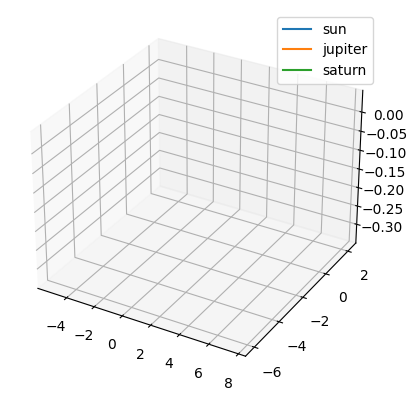

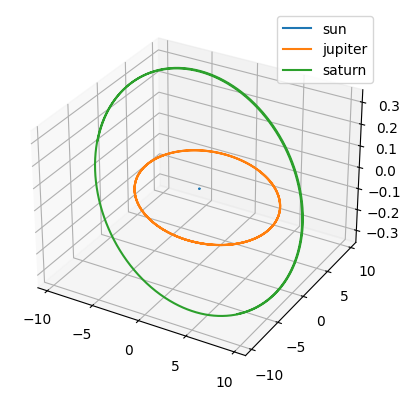

<Figure size 640x480 with 0 Axes>

tensor([[ 0.0000, -5.1837,  7.5457,  0.0000,  2.1433, -6.0924,  0.0000,  0.0476,
         -0.3438,  0.0000, -1.1021,  1.2620,  0.0000, -2.6656,  1.5631,  0.0000,
          0.0000,  0.0000]], requires_grad=True)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       grad_fn=<AddBackward0>)


In [15]:
lw = 3  #linewidth
fs = 9
ts = 15
tpad = 7
ls = 12


def load_model(args):
    output_dim = 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = hnn(args.input_dim, differentiable_model=nn_model, field_type=args.field_type)
    label = 'hnn'
    path = '{}/{}_{}.pt'.format(args.save_dir, args.name, label)
    model.load_state_dict(torch.load(path))
    return model


hnn_model = load_model(args)


def model_update(t, state, model):
    state = state.reshape(-1, 7)

    deriv = np.zeros_like(state)
    np_x = state[:, 1:]  # drop mass
    np_x = np_x.T.flatten()[None, :]
    x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_deriv(x)
    deriv[:, 1:] = dx_hat.detach().data.numpy().reshape(6, 3).T
    return deriv.reshape(-1)


np.random.seed(0)
t_points = 2000
t_span = [0, 50]
state = sjs()

orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)

update_fn = lambda t, y0: model_update(t, y0, hnn_model)

hnn_orbit, settings = get_nn_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)

# plot 3d hnn_orbit
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, planet in enumerate(hnn_orbit):
    ax.plot(planet[1], planet[2], planet[3], label={'0': 'sun', '1': 'jupiter', '2': 'saturn'}[str(i)])
ax.legend()
plt.show()

# plot 3d orbit
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, planet in enumerate(orbit):
    ax.plot(planet[1], planet[2], planet[3], label={'0': 'sun', '1': 'jupiter', '2': 'saturn'}[str(i)])
ax.legend()
plt.show()

"""
plt.subplot(1, 3, 2)
real_pe, real_ke, real_etot = potential_energy(orbit), kinetic_energy(orbit), total_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_pe, 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], real_ke, 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], real_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1, 3, 3)
plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], potential_energy(hnn_orbit), 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], kinetic_energy(hnn_orbit), 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], total_energy(hnn_orbit), 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)
"""

plt.tight_layout();
plt.show()

sstate = state.reshape(-1, 7)
deriv = np.zeros_like(sstate)
np_x = sstate[:, 1:]  # drop mass
np_x = np_x.T.flatten()[None, :]
x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32)
dx_hat = hnn_model.time_deriv(x)
deriv[:, 1:] = dx_hat.detach().data.numpy().reshape(6, 3).T
deriv = deriv.reshape(-1)

print(x)
print(hnn_model.time_deriv(x))